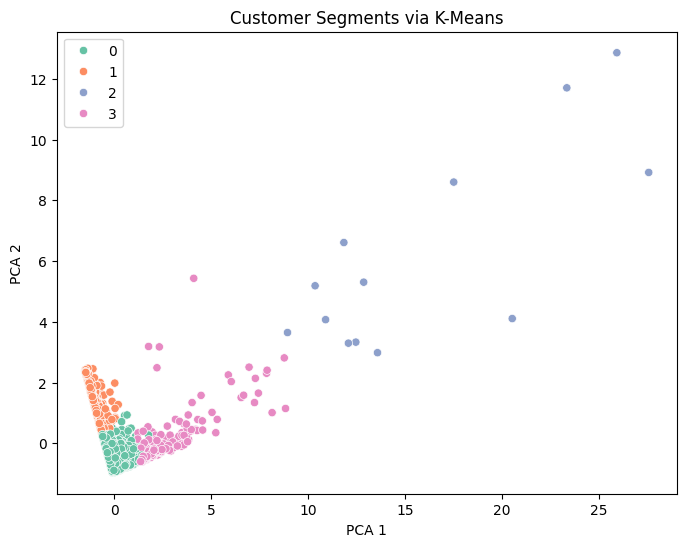

            Recency  Frequency       Monetary
Cluster                                      
0         42.702685   3.682711    1359.049284
1        247.075914   1.552015     480.617480
2          6.384615  82.538462  127338.313846
3         14.500000  22.333333   12709.090490
Saved: rfm_with_clusters.csv, kmeans_model.pkl, scaler.pkl


In [1]:
# Import libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load dataset from CSV
df = pd.read_csv("Online-Retail.csv", encoding="ISO-8859-1")

# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Clean data
df.dropna(subset=["CustomerID"], inplace=True)
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]

# Create TotalPrice column
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# Set reference date for Recency calculation
ref_date = df["InvoiceDate"].max()

# RFM Calculation
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (ref_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
}).rename(columns={
    "InvoiceDate": "Recency",
    "InvoiceNo": "Frequency",
    "TotalPrice": "Monetary"
})

# Standardize RFM
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# PCA for visualization
pca = PCA(n_components=2)
pca_rfm = pca.fit_transform(rfm_scaled)

# K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(rfm_scaled)
rfm["Cluster"] = clusters

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_rfm[:, 0], y=pca_rfm[:, 1], hue=clusters, palette="Set2")
plt.title("Customer Segments via K-Means")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

# Cluster summary
summary = rfm.groupby("Cluster").mean()
print(summary)

# Save model and scaler
with open("kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Save RFM with clusters
rfm.to_csv("rfm_with_clusters.csv")

print("Saved: rfm_with_clusters.csv, kmeans_model.pkl, scaler.pkl")
